<a href="https://colab.research.google.com/github/stmarple/MachineLearningWithTensorFlow/blob/master/FFNN_MNST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST (aka Modified National Institute of Standards and Technology Database) 
is a large database of handwritten digits used for training various image processing systems.
https://en.wikipedia.org/wiki/MNIST_database

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

### **Load and Prepare the MNIST Dataset**

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


### **Build the `tf.keras.Sequential` model by stacking layers**

In [0]:
modelA = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

modelA.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### **Train and evaluate the model**
Before we begin, we should go over a few important **hyperparameters**:

1. epoch, which is the total training sequences
2. batch_size, which is the training batch size
3. display_freq, which is the frequency of results displaying
4. learning_rate, which is the initial optimization learning rate

see https://www.easy-tensorflow.com/tf-tutorials/neural-networks/two-layer-neural-network?view=article&id=124:two-layer-neural-network for more information.

In [36]:
historyA = modelA.fit(x_train, y_train, epochs=5)
loss, accuracy  = modelA.evaluate(x_test,  y_test, verbose=2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.2488 - acc: 0.9272
Epoch 2/5
60000/60000 [==============================] - 7s 114us/sample - loss: 0.1140 - acc: 0.9659
Epoch 3/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.0816 - acc: 0.9746
Epoch 4/5
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0661 - acc: 0.9787
Epoch 5/5
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0531 - acc: 0.9829
10000/10000 - 0s - loss: 0.0695 - acc: 0.9788


**Shape**

From here, we can extrapolate that the training data set has 60,000 samples of images with the dimensions 28 X 28.  We also see that the test sample is composed of 10,000 samples of images of the same dimensions.

In [37]:
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (60000, 28, 28)
Test data shape:  (10000, 28, 28)


**Flatten Images**

The image vector size is the square units of each image.  In this case, 28 * 28, or 784.   
As we saw above, x_train = [60000, 28, 28], so x_train[0] is equal to our sample size, or 60,000.    
As the section says, we are trying to flatten this image.  Rather than being 3 dimensional 60k X 28 X 28,
we are flattening the image population down to area.  So we will be down to (sample size, area) for each: training set and test set.

In [0]:
img_vector_size = 28**2
x_train = x_train.reshape(x_train.shape[0], img_vector_size)
x_test = x_test.reshape(x_test.shape[0], img_vector_size)

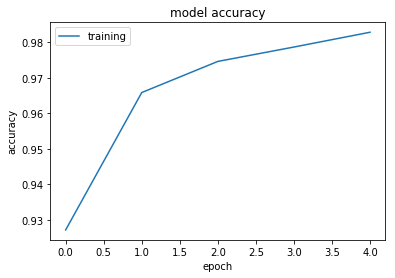

Test loss: 0.0695
Test accuracy: 0.979


In [39]:
import matplotlib.pyplot as plt

plt.plot(historyA.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


*** Now that looks like some good accuracy, with small amounts of test loss! ***

Let's see what it looks like when applied to a hand-written digit...

In [0]:
from random import randint,sample

def test_model(img):
  plt.figure
  plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
  pred = modelA.predict(x_test[img].reshape(1, 28, 28))
  return pred.argmax()

1


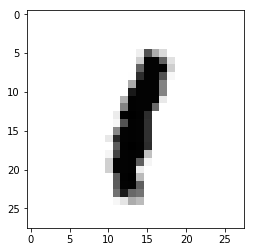

In [41]:
img = randint(1,5000)
plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
pred = modelA.predict(x_test[img].reshape(1, 28, 28))
print(pred.argmax())

*** Looks like this classifies these digits pretty well! ***
# In this next section... 
We will discuss alternate methods of achieving similiar success.  We will look to add nodes and layers, we will choose different optimizers and activation functions and see how that changes the outcome.  We will also go step-by-step on the models work, what each optimizer and activation functions are [that we may use in a problem like this], as well as how the steps are calculated to get a decent understanding on how the model works behind the scenes to enable us to build a foundation for understanding machine learning.



---



# Classification of MNIST Digits
https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3 

Before we get started, there a just few things we should talk about:  
* **Training data** is the data that our model will be learning from
* **Test data** is the data that is kept a secret until after the model has been trained, and then evaluated against
* A **loss function** is used to quantify how accurate our model's predictions are. 
  These are the amount of error involved.  Some typical loss functions are:
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)
  - Mean Bias Error (MBE)
  - Cross Entropy Loss / Negative Log Likelihood
  
  Many of these I have seen in my studies in Statistics
* An **optimization algorithm** controls the weights, that are adjusted during training.



For more information on loss functions, you can find it here:

https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23


### Calculating Cross Entropy Loss
Since Cross Entropy Loss is the most common setting for classification problems, we will take a closer look at its calculation.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np

# Cross Entropy:
## H(p, q) = E<sub>p</sub> [ -log q(x) ] = -$\sum_{i}^C$ p<sub>i</sub>(x) * LN q<sub>i</sub>(x)
Where:
* p is the true probability, given the distribution
* q is the predicted value of the current model
* C is the number of classes, which in our digit classification problem, would be 10

### _So, let's try to understand this a bit_
 
Say we have an image of digits: a 2 and a 9.
Each image can only be entirely one number on a scale of 0 to 9. 

#### Therefore our vector would look like this: 

> p<sub>1</sub> = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

There is 0 probability of being any other number but the one the image is supposed to be.

### Now, let's say we have a machine learning model that classifies the image with probabilities of:

> q<sub>1</sub> = [0.0, 0.0, 0.65, 0.15, 0.0, 0.0, 0.0, 0.20, 0.0, 0.0]

Cross entropy can be calculated on this single image as:

-$\sum_{i}^C$ p<sub>i</sub>(x) * log q<sub>i</sub>(x) 

= - (0 * LN(0) + 0 * LN(0) + 1 * LN(0.65) + 0 * LN(0.15) + 0 * LN(0) + 0 * LN(0.20) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0))

= - (LN(0.65))

= 0.43078

### Now, lets say the model was able to get better and classifies the probabilies of this image as:
q<sub>1</sub> = [0.0, 0.0, 0.95, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

So, 

-$\sum_{i}^C$ p<sub>i</sub>(x) * log q<sub>i</sub>(x) 

= - (0 * LN(0) + 0 * LN(0) + 1 * LN(0.95) + 0 * LN(0.05) + 0 * LN(0) + 0 * LN(0.20) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0))

= - (LN(0.95))

= 0.05129

**This is much better!**

#### If you would like to get more information on this, see: 
* https://en.wikipedia.org/wiki/Cross_entropy 
* https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* https://medium.com/activating-robotic-minds/demystifying-cross-entropy-e80e3ad54a8
* A Questionable StackOverflow CE function: https://stackoverflow.com/questions/49473587/how-to-compute-log-loss-same-as-cross-entropy

In [82]:
def cross_entropy(x, y):
    x = [element if element > 0 else 1 for element in x] # replace prediction probabilities of 0 to prevent LN(0), which is undefined.  Instead replace LN(1) = 0, which cancels out the term anyway
    print(x)
    pred = np.array(x)
    targ = np.array(y)
    
    N = pred.shape[0] # A stack overflow divided by this number, which seems to conflict with my research (see above)
    return -np.sum(targ*np.log(pred))

predictions = [0.0, 0.0, 0.65, 0.15, 0.0, 0.20, 0.0, 0.0, 0.0, 0.0]
targets     = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

cross_entropy(predictions, targets)

[1, 1, 0.65, 0.15, 1, 0.2, 1, 1, 1, 1]


0.4307829160924542

# Example 2: Building a Highly Accurate Image Classifification Model Step-by-Step
## Create a Vector

In [44]:
import keras
from keras.datasets import mnist

# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training label shape: '   , y_train.shape) # 60000 numbers (all 0-9)
print('First 5 training labels: ', y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to vectors using the to_categorical function
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('First 5 training lables as one-hot encoded vectors:\n', y_train[:5])


Training label shape:  (60000,)
First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


The **number of classes** represents the number of unique digits we have.  This will be the number of categories we can split them up into.  This number represents the number of output nodes or probabilities.

### For fully connected neural networks, there are three essential questions that define the network’s architecture:
1. How many layers are there?
2. How many nodes are there in each of those layers?
3. What transfer/activation function is used at each of those layers?

### There are 2 factors that contribute to the performance of a neural network: 
* The loss function  
* The optimization algorithm used

Per the article mentioned above, the author selects:
* A *common loss function*: **the categorical cross entropy** and 
* One of the simpler *optimization alogorithms*: **the stocastic gradient descent (SGD)**

**What is cross entropy loss?**  It is a log loss that measures the performance of a classification model whose output is based on a probability between 0 and 1.

More information on loss functions and optimiizers can be found here: https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd

## Creating First Model
Dense layers are "fully connected" layers
Documentation: https://keras.io/models/sequential/

* The input layer requires the special input_shape parameter which should match the shape of our training data.
* The image_size is a created by flattening an image to 28 X 28 or 28<sup>2</sup>  = 784
* This model has a single hidden layer, that has 32 nodes, or 32 biases using the sigmoid activation function
* And, since there are 784 square units, on 1 layer, that has 32 nodes, there are 784 x 1 x 32 = 25,088 weights, where weights represent the number of pixels
* Therefore, there are 25,088 + 32 biases = 25,120 parameters
* There are 32 x 10, or 320 weights from hidden layer to output layer.
* Each of the 10 nodes adds a single bias >> 25,120 par + 320 weights + 10 nodes = 25,450 total parameters



In [45]:
from keras.layers import Dense, Flatten 
from keras.models import Sequential 

image_size = 784 # 28*28
num_classes = 10 # ten unique digits

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### This model contains a special activation function: the softmax.
What makes it special is that it normalizes the values from the 10 output nodes in such a way that:
* all the values are between 0 and 1
* the sum of all 10 values = 1

To put it another way, Softmax "calculates the probabilities distribution of the event over 'n' different events".  In this case, there are 10 possible probabilities, with the largest as the prediction vector.  These probabilities "will be helpful when determining the target class for the given inputs".

More information on activation functions can be found here:
https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html


## Train and Evaluate The Model

In [46]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.05)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Train on 57000 samples, validate on 3000 samples
Epoch 1/5
57000/57000 [==============================] - 2s 29us/step - loss: 1.4128 - acc: 0.6259 - val_loss: 0.9406 - val_acc: 0.8283
Epoch 2/5
57000/57000 [==============================] - 1s 23us/step - loss: 0.8520 - acc: 0.8231 - val_loss: 0.6726 - val_acc: 0.8770
Epoch 3/5
57000/57000 [==============================] - 1s 21us/step - loss: 0.6710 - acc: 0.8585 - val_loss: 0.5443 - val_acc: 0.8987
Epoch 4/5
57000/57000 [==============================] - 1s 22us/step - loss: 0.5768 - acc: 0.8727 - val_loss: 0.4583 - val_acc: 0.9053
Epoch 5/5
57000/57000 [==============================] - 1s 22us/step - loss: 0.5159 - acc: 0.8821 - val_loss: 0.4095 - val_acc: 0.9160


### Graph That

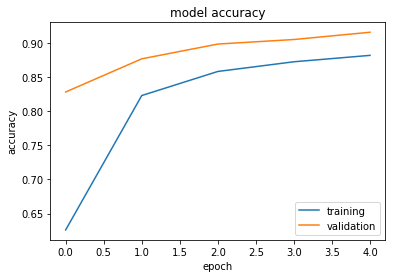

Test loss: 0.474
Test accuracy: 0.897


In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## Create, Test, Evaluate, and Graph Again
This time, rather than having a single layer with only 32 nodes, let's increase that to 128 nodes

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 2s 45us/step - loss: 1.0157 - acc: 0.7374 - val_loss: 0.5543 - val_acc: 0.8812
Epoch 2/5
54000/54000 [==============================] - 2s 35us/step - loss: 0.5321 - acc: 0.8710 - val_loss: 0.4008 - val_acc: 0.9058
Epoch 3/5
54000/54000 [==============================] - 

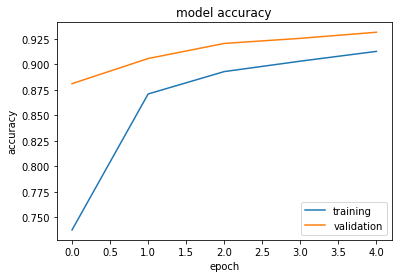

Test loss: 0.314
Test accuracy: 0.917


In [48]:
image_size = 784 # 28*28
num_classes = 10 # ten unique digits

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units=128, activation='sigmoid', input_shape=(image_size,))) # increase from 32 nodes to 128 **
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

It looks like the training model has gotten much better.  However, there is still much to be done about the test loss of more than 32%.

### Let's see what this model can predict...

1


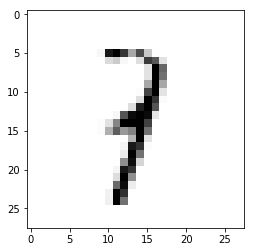

In [49]:
img = 1500
plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
pred = model.predict(x_test[img].reshape(1, 28, 28))
print(pred.argmax())

*** Looks like we still have some work to do! ***

This image is obviously not a 1.  We will look to increase accuracy in the next section.

## Network Depth and Layer Width
https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3 **continues...**
